# Identify Peaks by Derivative

In [1]:
# For implementing the interactive feature

In [2]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib
import re

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13.75}

matplotlib.rc('font', **font)

In [3]:
datafile = 'data/20200423_scan6_background_corrected.csv'

k = np.genfromtxt(datafile, delimiter=',')[0:,0][500:1300]
a_nosmooth = np.genfromtxt(datafile, delimiter=',')[0:,1][500:1300]

# Smooth data, take derivative, smooth derivative, take derivative, smooth derivative

a = gaussian_filter1d(a_nosmooth, 5)

#a = savgol_filter(a_nosmooth, 33, 3)
da = gaussian_filter1d(np.gradient(a), 3)
#da = savgol_filter(da, 5, 1)
dda = gaussian_filter1d(np.gradient(da), 3)
#dda = savgol_filter(dda, 25, 3)

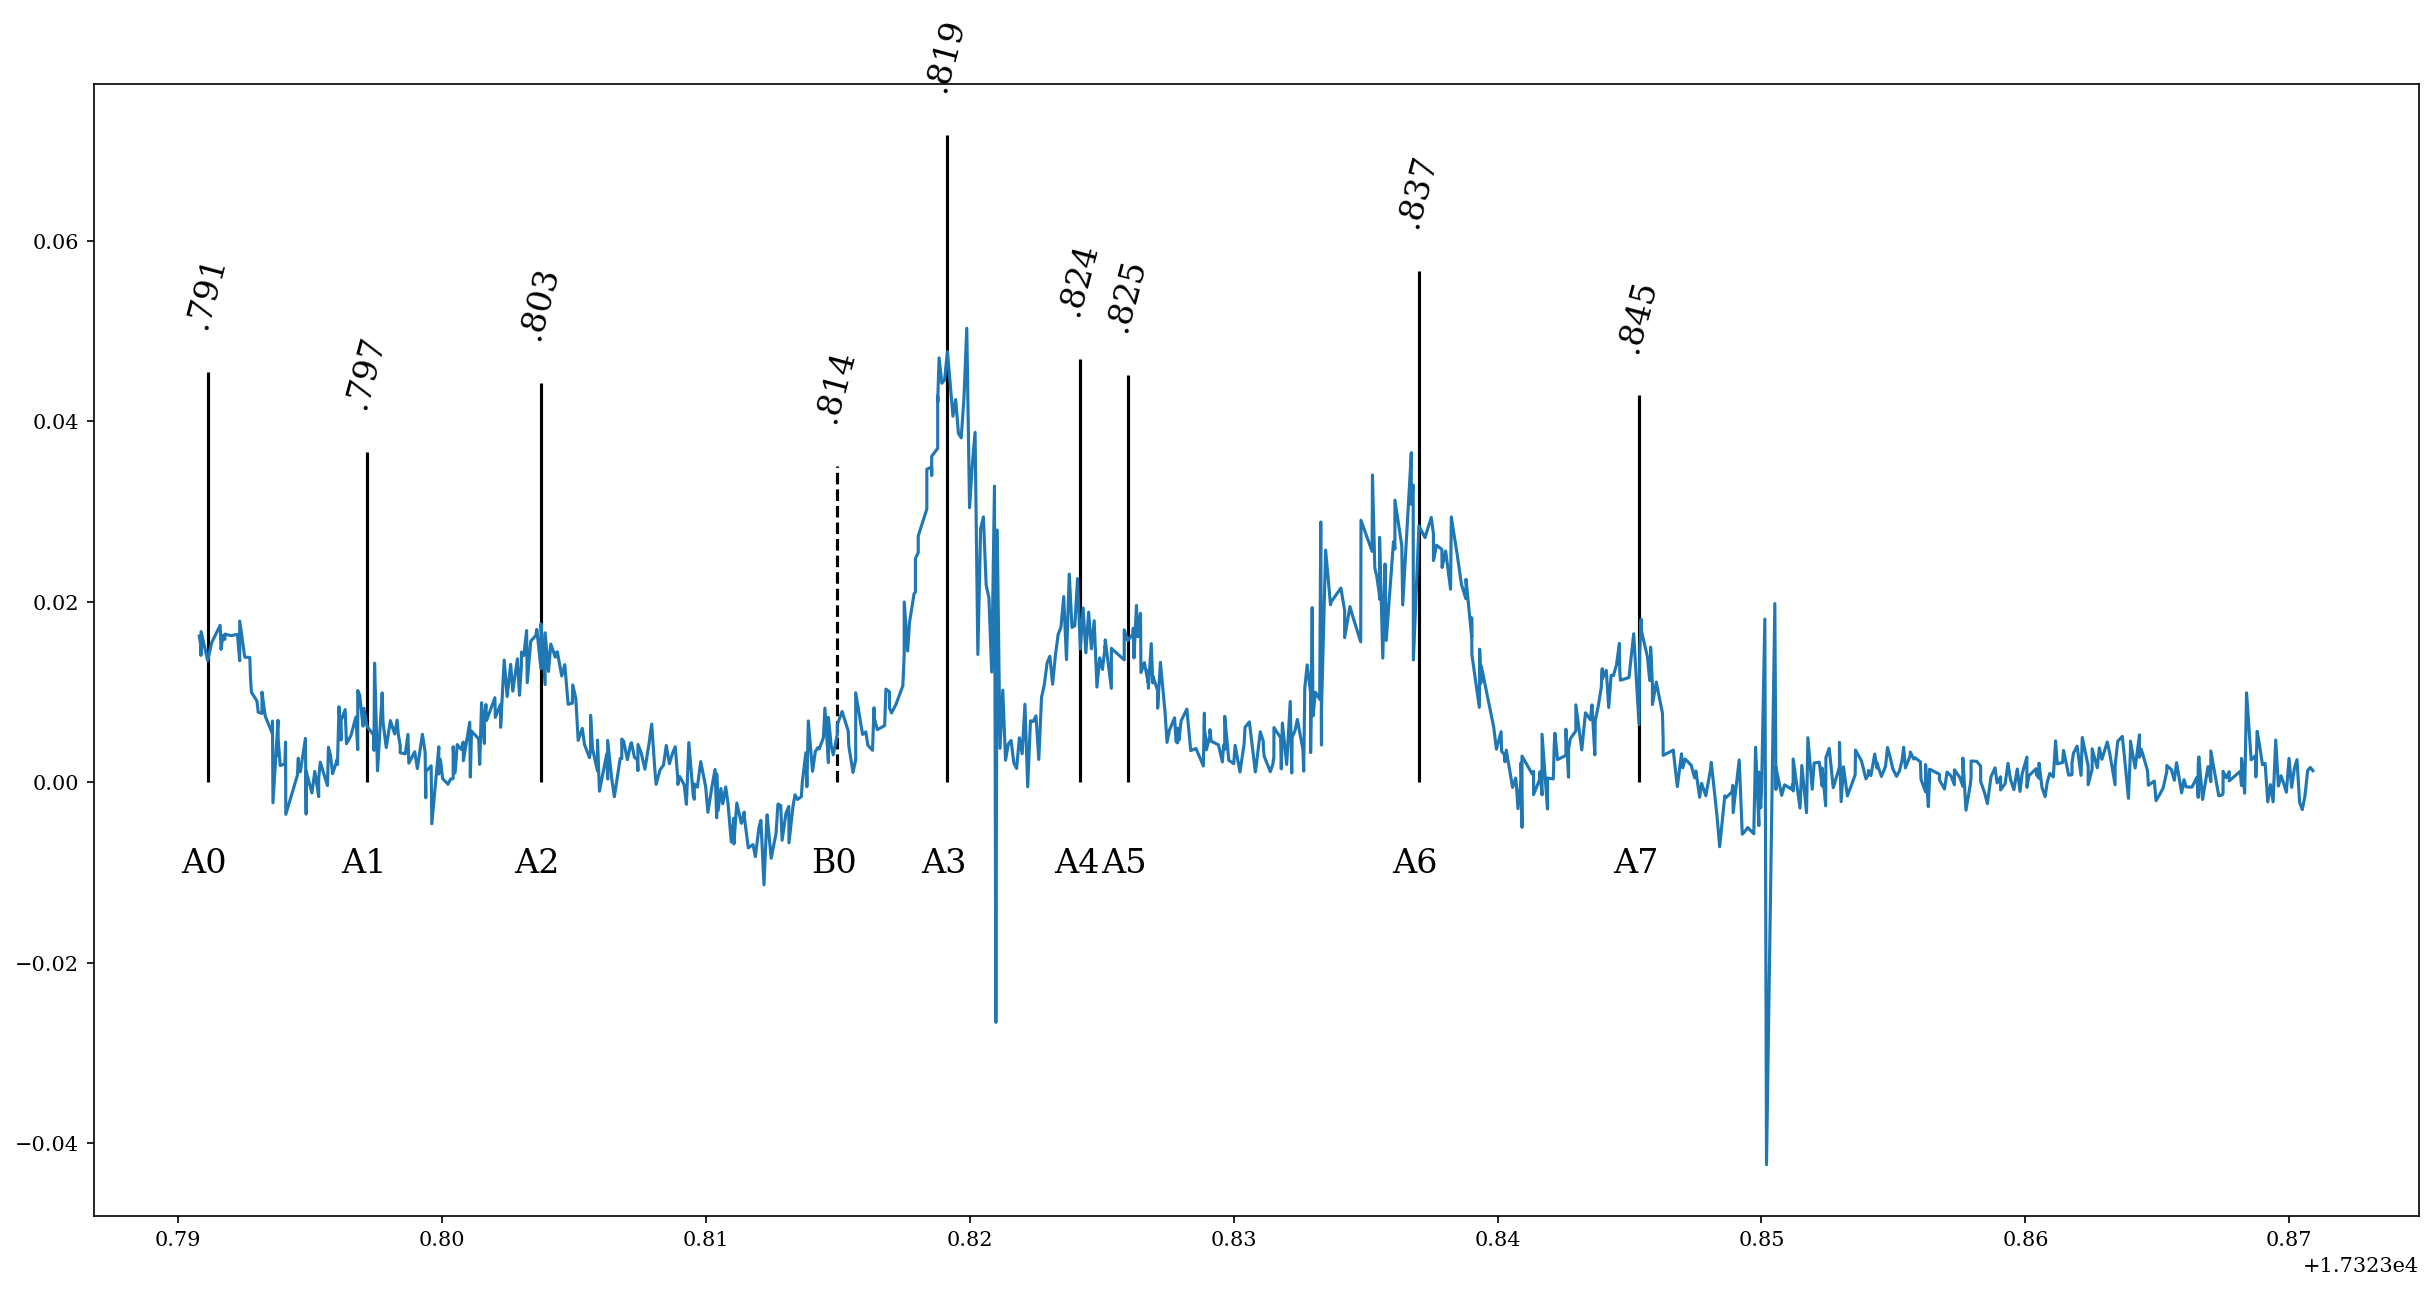

In [12]:
# Find peaks
threshold = .005 # Minimum height of peak
peaks1 = [] # Pretty sure there are peaks here (da goes from + to -)
peaks2 = [] # Not as sure there are peaks here (less sensitive condition: dda < 0)

for i in range(1, len(a)):
    if da[i-1]>0 and da[i]<0 and a[i]>threshold:
        peaks1.append(i)
    if dda[i] < 0 and a[i]>threshold:
        peaks2.append(i)
        
# Average nearby peak locations (could maybe get width from this) (only needed for peaks2)
runs = [[]]
for i in range(1,len(peaks2)):
    if peaks2[i] <= peaks2[i-1]+8:
        runs[-1].append(peaks2[i])
    else:
        runs.append([])
        runs[-1].append(peaks2[i])
        
# Remove runs containing a certain peak1
runs2 = []
for run in runs:
    if set(peaks1).isdisjoint(run) and not run in runs2:
        runs2.append(run)
runs = runs2

peaks2 = [int(mean(run)) for run in runs]
peaks = peaks1 + peaks2

peak_widths = [.5*len(run)*(k[1]-k[0]) for run in runs] #Some ill-defined measure of uncertainty/width. Currently not used

k_peaks1 = k[peaks1]
k_peaks2 = k[peaks2]
k_peaks = k[peaks]

# Plot location and values of lines
fig, ax = plt.subplots(figsize=(20, 10),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

h = .03
ax.plot(k, a_nosmooth)

def plotline(peaks):
    ax.vlines(k[peaks[i]], 0, a[peaks[i]]+h, linestyle='--' if peaks==peaks2 else '-')
    ax.text(k[peaks[i]]-.001, 
            a[peaks[i]]+h*1.15, str(k[peaks[i]]-int(k[0]))[1:5], 
            fontsize=16, rotation=75, va='bottom')
    ax.text(k[peaks[i]]-.001, 
            -.01, 'A'+str(i) if peaks==peaks1 else 'B'+str(i), 
            fontsize=16)

for i in range(len(peaks1)):
    plotline(peaks1)
for i in range(len(peaks2)):
    plotline(peaks2)
    
plt.show()